In [190]:
! pip install mysql-connector-python

In [191]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy

import mysql.connector
from mysql.connector import Error
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [192]:
connection = mysql.connector.connect(
        host='ds50-mysql-do-user-9644544-0.b.db.ondigitalocean.com',
        database='ds50',
        user='ds50',
        password='AVNS_4ybSd0CoPKnCL5F',
        port = '25060')
if connection.is_connected():
        data = pd.read_sql( '''SELECT * FROM REVIEW LIMIT 5000 
        ''', connection)
        connection.close()
data=pd.DataFrame(data)


C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [193]:
data.head(15)


,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,0000070d5b02a290c631438f4f618c48,644915,2318271,5,"Meski sudah banyak orang tahu buku ini, namun ...",2010-05-13 13:04:33,NaT,0,0
1,00000dd80b43a2cf2afee588cfdd72e2,141599,28954189,5,Death can be cured and aging reversed. The nee...,2017-02-16 19:00:04,2017-03-24 07:00:00,0,0
2,00001391db9e5a03e3f13da55399d427,157659,16043719,2,The Marriage Mistake focuses on Count's younge...,2012-11-30 03:45:25,2012-12-18 08:00:00,0,0
3,00001da050362c5a7eaf6a0614385a29,184748,15507958,5,When I saw the trailer for the movie version o...,2016-08-17 13:31:06,2016-07-27 07:00:00,0,0
4,00002061af3a9f981f601d7f223a6b35,154981,12578313,4,I didn't expect to enjoy this as much as I did...,2013-12-02 21:27:56,NaT,0,0
5,0000271000ca3f0ed54ec992fa502672,57501,13418329,5,In 1999 a friend of mine suggested I read this...,2013-09-07 19:49:37,2017-05-03 07:00:00,0,0
6,00002956a602b00f44b4d2e42eec50b8,105694,15283043,5,This is one of the very few books that I loved...,2013-07-13 15:49:37,NaT,0,0
7,00002e84abd11229f94cad76a601f288,395328,4588,5,Made me cry on the subway- but in a really goo...,2007-12-27 00:57:37,NaT,0,0
8,000039a2fc73f37e615c4acc4498116a,218600,12444166,5,What an awesome read. So kicking myself for pu...,2012-03-29 23:07:35,2013-03-26 07:00:00,1,0
9,00004fead2419af82ee3c84b533dea27,256390,2743,5,I read this many years ago and I still talk ab...,2010-07-27 03:28:05,NaT,0,0


In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    5000 non-null   object        
 1   user_id      5000 non-null   int64         
 2   book_id      5000 non-null   int64         
 3   rating       5000 non-null   int64         
 4   review_text  5000 non-null   object        
 5   date_added   5000 non-null   datetime64[ns]
 6   started_at   3000 non-null   datetime64[ns]
 7   n_votes      5000 non-null   int64         
 8   n_comments   5000 non-null   int64         
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 351.7+ KB


In [195]:
data = data[(data['review_text'].str.len() > 3) & (data['review_text'].str.len() < 3000) & (((~ data['review_text'].str.isdigit()) & (data['review_text'].str.len() != 0)) | (data['rating'] != 0))]


In [196]:
data.shape
data = data.reset_index()
data = data.drop(columns=["index"])
data.head(38)

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,00000dd80b43a2cf2afee588cfdd72e2,141599,28954189,5,Death can be cured and aging reversed. The nee...,2017-02-16 19:00:04,2017-03-24 07:00:00,0,0
1,00001391db9e5a03e3f13da55399d427,157659,16043719,2,The Marriage Mistake focuses on Count's younge...,2012-11-30 03:45:25,2012-12-18 08:00:00,0,0
2,00001da050362c5a7eaf6a0614385a29,184748,15507958,5,When I saw the trailer for the movie version o...,2016-08-17 13:31:06,2016-07-27 07:00:00,0,0
3,00002061af3a9f981f601d7f223a6b35,154981,12578313,4,I didn't expect to enjoy this as much as I did...,2013-12-02 21:27:56,NaT,0,0
4,0000271000ca3f0ed54ec992fa502672,57501,13418329,5,In 1999 a friend of mine suggested I read this...,2013-09-07 19:49:37,2017-05-03 07:00:00,0,0
5,00002956a602b00f44b4d2e42eec50b8,105694,15283043,5,This is one of the very few books that I loved...,2013-07-13 15:49:37,NaT,0,0
6,00002e84abd11229f94cad76a601f288,395328,4588,5,Made me cry on the subway- but in a really goo...,2007-12-27 00:57:37,NaT,0,0
7,000039a2fc73f37e615c4acc4498116a,218600,12444166,5,What an awesome read. So kicking myself for pu...,2012-03-29 23:07:35,2013-03-26 07:00:00,1,0
8,00004fead2419af82ee3c84b533dea27,256390,2743,5,I read this many years ago and I still talk ab...,2010-07-27 03:28:05,NaT,0,0
9,000062f0c7b8c3c3ca0c5c280afa3b48,236470,13638125,4,'Vicious' is a super-powers/urban fantasy with...,2016-06-16 17:01:38,2016-06-18 07:00:00,1,0


In [198]:
data.loc[898,'review_text']

'**4,5**'

In [146]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False


In [186]:
import re 
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# to remove stopword
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

import deep_translator as dt
from langdetect import detect 

corpus = []

def convert_pos(pos):
    if pos[0] in POS_CONVERSION:
        return POS_CONVERSION[pos[0]]
    else:
        return wordnet.NOUN

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


for i in range(0, len(data)):
    if data['review_text'].iloc[i].isdigit() or isfloat(data['review_text'].iloc[i]):
        if i == 820:
            print(f"Nous sommes ligne 820 !!!")
        if float(data['review_text'].iloc[i])>=0 and float(data['review_text'].iloc[i])<= 1:
            data.loc[i,'review_text']="bad"
        elif float(data['review_text'].iloc[i])>1 and float(data['review_text'].iloc[i])<= 2:
            data.loc[i,'review_text']="not bad"
        elif float(data['review_text'].iloc[i])>2 and float(data['review_text'].iloc[i])<= 3:
            data.loc[i,'review_text']="average"
        elif float(data['review_text'].iloc[i])>3 and float(data['review_text'].iloc[i])<= 4:
            data.loc[i,'review_text']="good"
        elif float(data['review_text'].iloc[i])>4 and float(data['review_text'].iloc[i])<= 5:
            data.loc[i,'review_text']="very good"
        else:
            #si c'est supérieur à 5, on mets le commentaire en fonction de la note attribué
            #print(f"nous sommes ligne {i} et le rating et {data['rating'].iloc[i]}")
            match int(data.loc[i,'rating']):
                case 1:
                    data.loc[i,'review_text']="bad"
                case 2:
                    data.loc[i,'review_text']="not bad"
                case 3:
                    data.loc[i,'review_text']="average"
                case 4:
                    data.loc[i,'review_text']="good"
                case 5:
                    data.loc[i,'review_text']="very good"
    elif len(data['review_text'].iloc[i]) == 0:
        #si c'est vide, on mets le commentaire en fonction de la note attribué
        #print(f"nous sommes ligne {i} et le rating et {data['rating'].iloc[i]}")
        match int(data.loc[i,'rating']):
            case 1:
                data.loc[i,'review_text']="bad"
            case 2:
                data.loc[i,'review_text']="not bad"
            case 3:
                print(f"Nous sommes ligne {i} !!!")
                data.loc[i,'review_text']="average"
            case 4:
                data.loc[i,'review_text']="good"
            case 5:
                data.loc[i,'review_text']="very good"       
    else:
        # Traduction                      
        review=data.loc[i,'review_text']
        try:
            temp = detect(review)
        except Exception as lde:
            print(f"Exception : Nous sommes ligne : {i}, l'exeption est {lde}")
            temp = 'en'

        if (len(review) != 0 and not review.isspace()) and temp!="en":
            print(f"ligne {i}")
            translated = dt.GoogleTranslator(source='auto', target='en').translate(text=review)
            data.loc[i,'review_text']== translated
        
        #review = remove_punctuation(data['review_text'].iloc[i])

        # convert all cases to lower cases
        review = review.lower()

        # split to array(default delimiter is " ")
        review = nltk.word_tokenize(review)

        POS_CONVERSION = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

        tags = pos_tag(review)
        lemmatizer = WordNetLemmatizer()
        
        review = [lemmatizer.lemmatize(word, pos=convert_pos(pos)) for word, pos in tags
                    if word not in set(stopwords.words("english"))]

        review = ' '.join(review) 

        corpus.append(review)
        data.loc[i,'review_text']=review

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


ligne 17
ligne 26
ligne 27
ligne 39
ligne 45
ligne 55
ligne 60
ligne 64
ligne 74
ligne 108
ligne 111
ligne 131
ligne 151
ligne 189
ligne 190
ligne 204
ligne 210
ligne 213
ligne 222
ligne 245
ligne 260
ligne 264
ligne 270
ligne 273
ligne 274
ligne 275
ligne 287
ligne 292
ligne 296
ligne 301
ligne 303
ligne 305
ligne 309
ligne 321
ligne 329
ligne 333
ligne 334
ligne 336
ligne 337
ligne 340
ligne 358
ligne 380
ligne 381
ligne 386
ligne 394
ligne 395
ligne 401
ligne 415
ligne 417
ligne 431
ligne 439
ligne 454
ligne 480
ligne 495
ligne 513
ligne 518
ligne 520
ligne 522
ligne 554
ligne 567
ligne 571
ligne 578
ligne 579
ligne 585
ligne 590
ligne 591
ligne 592
ligne 594
ligne 601
ligne 607
ligne 615
ligne 618
ligne 620
ligne 621
ligne 626
ligne 650
ligne 664
ligne 679
ligne 698
ligne 718
ligne 731
ligne 752
ligne 779
ligne 798
ligne 808
ligne 810
Exception : Nous sommes ligne : 820, l'exeption est No features in text.
ligne 839
ligne 879
Exception : Nous sommes ligne : 898, l'exeption est No f

KeyboardInterrupt: 

****Translate****

In [ ]:
!pip install -U deep-translator

In [ ]:
!pip install langdetect

In [ ]:

data[data['rating'] == 0].head()

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
24,0000cae0b06557b0495712faf7ecd5cb,163574.0,2728527.0,0.0,"like pretty good , sometimes go stuff really n...",2013-01-06 22:15:27,NaT,0.0,0.0
27,0000d670cf35a0d3b282b75677ebc3e3,155108.0,6801582.0,0.0,far ... favorite ...,2014-03-23 22:02:32,NaT,0.0,1.0
45,00014ce2588a1150b63ad4931f49482d,153431.0,1582996.0,0.0,awesome,2014-02-05 09:25:27,NaT,0.0,0.0
51,00018b496d5b68ff7f3f2f2d36342fab,358924.0,24817626.0,0.0,"really enjoy story . find three narrator 's , ...",2015-02-04 03:26:21,2015-08-11 07:00:00,0.0,0.0
81,000256fde4288f4ca192a6f6d80b55ed,51641.0,25695756.0,0.0,awesome book . highly recommend !,2014-01-20 21:09:38,2017-02-20 08:00:00,0.0,0.0


**Ratings count**

<AxesSubplot:xlabel='rating', ylabel='count'>

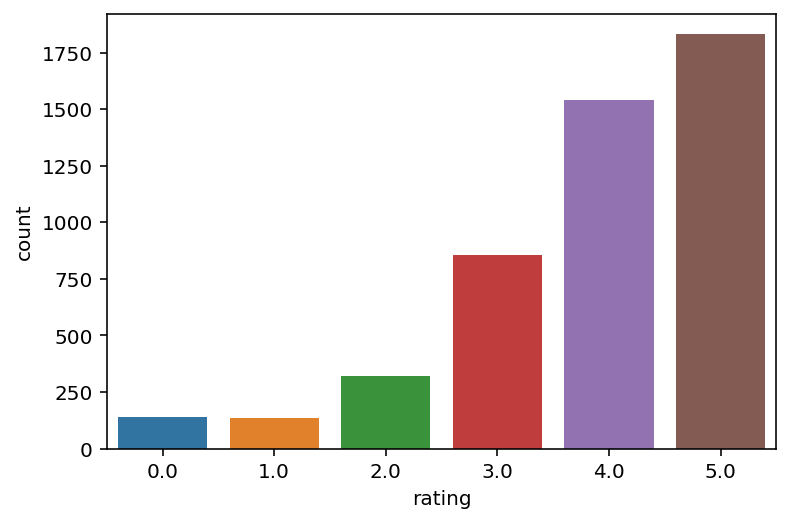

In [ ]:
import seaborn as sns
sns.countplot(x=data['rating'],data=data)

In [ ]:
ratings_equal_zero=data[data['rating']==0]


In [ ]:
data=data[['review_id', 'rating', 'review_text']]
data.head()

,review_id,rating,review_text
1,00000dd80b43a2cf2afee588cfdd72e2,5.0,marriage mistake focus count 's young sister c...
2,00001391db9e5a03e3f13da55399d427,2.0,saw trailer movie version book fell love chara...
3,00001da050362c5a7eaf6a0614385a29,5.0,"n't expect enjoy much . great work , good idea..."
4,00002061af3a9f981f601d7f223a6b35,4.0,1999 friend mine suggest read book . try read ...
5,0000271000ca3f0ed54ec992fa502672,5.0,one book love first sentence last . cayman hil...


In [ ]:
rate_id_one = []
rate_id_two = []
rate_id_three = []
rate_id_four = []
rate_id_five =[]


for review_text, rating in zip(data['review_text'], data['rating']):
    line = review_text.split(" ")
    dic = {}
    if rating == 1:
        for word in line:
            dic[word] = True
        ireru = (dic, 1)
        rate_id_one.append(ireru)
    elif rating == 2:
        for word in line:
            dic[word] = True
        ireru = (dic, 2)
        rate_id_two.append(ireru) 
    elif rating == 3:
        for word in line:
            dic[word] = True
        ireru = (dic, 3)
        rate_id_three.append(ireru)
    elif rating == 4:
        for word in line:
            dic[word] = True
        ireru = (dic, 4)
        rate_id_four.append(ireru)
    else:
        for word in line:
            dic[word] = True
        ireru = (dic, 5)
        rate_id_five.append(ireru)


In [ ]:
threshold = 0.8
num_one = int(threshold * len(rate_id_one))
num_two = int(threshold * len(rate_id_two))
num_three = int(threshold * len(rate_id_three))
num_four = int(threshold * len(rate_id_four))
num_five = int(threshold * len(rate_id_five))

features_train = rate_id_one[:num_one] + rate_id_two[:num_two] + rate_id_three[:num_three] + rate_id_four[:num_four] + rate_id_five[:num_five]
features_test = rate_id_one[num_one:] + rate_id_two[num_two:] + rate_id_three[num_three:] + rate_id_four[num_four:] + rate_id_five[num_five:]
print("Number of training datapoints:", len(features_train))
print("Number of test datapoints:", len(features_test))

Number of training datapoints: 3993
Number of test datapoints: 1001


In [ ]:
classifier = NaiveBayesClassifier.train(features_train)
print('Accuracy of the classifier:', nltk_accuracy(classifier, features_test))

Accuracy of the classifier: 0.12987012987012986


The cause may be that there is a wide range of choices from 1 to 5 and that the absolute number of low-rated sentence data is insufficient. For example, if you choose between 1 and 5 rates, it may improve.

Alternatively, if other methods are used, the accuracy may be further improved, so this will be an issue for the future.

words influenced the predicted numbers during the training.

In [ ]:
N = 30
print('Top ' + str(N) + ' most informative words:')
for i, item in enumerate(classifier.most_informative_features()[:N]):
    print(str(i+1) + '. ' + item[0]) 

Top 30 most informative words:
1. miserable
2. escrita
3. gather
4. partes
5. ancient
6. cruise
7. execution
8. hollow
9. inconsistent
10. internet
11. li
12. light-hearted
13. stomach
14. torture
15. victorian
16. whiny
17. ano
18. cup
19. darker
20. impressed
21. owner
22. sand
23. storyteller
24. upset
25. varias
26. 'hbbt
27. 3/4
28. 8th
29. 90
30. accomplish


In [ ]:
def extract_features(words):
    return dict([(word, True) for word in words])
#Divide into words like the large amount of review text earlier


print("Clothes review predictions:")

 
for i in range(0, len(data)):
    if data['rating'].iloc[i]==0 :
        input_review = data['review_text'].iloc[i]
        features = extract_features(input_review.split())
        probabilities = classifier.prob_classify(features)
        predicted_sentiment = probabilities.max()
        data['rating'].iloc[i]=predicted_sentiment
        

Clothes review predictions:


C:\Users\antoi\AppData\Local\Temp\ipykernel_7600\299568596.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating'].iloc[i]=predicted_sentiment


In [ ]:
ratings_equal_zero = data[data['rating']==0] 
ratings_equal_zero.head()

,review_id,rating,review_text


there is no ratings equal to 0

In [ ]:
data.head(30)

,review_id,rating,review_text
1,00000dd80b43a2cf2afee588cfdd72e2,5.0,marriage mistake focus count 's young sister c...
2,00001391db9e5a03e3f13da55399d427,2.0,saw trailer movie version book fell love chara...
3,00001da050362c5a7eaf6a0614385a29,5.0,"n't expect enjoy much . great work , good idea..."
4,00002061af3a9f981f601d7f223a6b35,4.0,1999 friend mine suggest read book . try read ...
5,0000271000ca3f0ed54ec992fa502672,5.0,one book love first sentence last . cayman hil...
6,00002956a602b00f44b4d2e42eec50b8,5.0,make cry subway- really good way .
7,00002e84abd11229f94cad76a601f288,5.0,awesome read . kick put long thinking 'd hate ...
8,000039a2fc73f37e615c4acc4498116a,5.0,read many year ago still talk day . even thoug...
9,00004fead2419af82ee3c84b533dea27,5.0,'vicious ' super-powers/urban fantasy interest...
10,000062f0c7b8c3c3ca0c5c280afa3b48,4.0,story several family milwaukee struggle make r...
